# 1D Plasticity Theory

In [1]:
from matplotlib import pyplot as plt
import numpy as np

## Loading only (NO History)

In [2]:
E_EL = pow(10,7)
E_P = pow(10,6)
eng_strain = np.linspace(0,4.0,num=400)

k_init = pow(10,7)
eng_strain_init = k_init/E_EL

In [3]:
eng_stress = np.empty(eng_strain.size);
for (i,element) in enumerate(eng_strain):
    if eng_strain_init > element:
        eng_stress[i] = E_EL * element
    else:
        eng_stress[i]= k_init + E_P *(element-eng_strain_init)

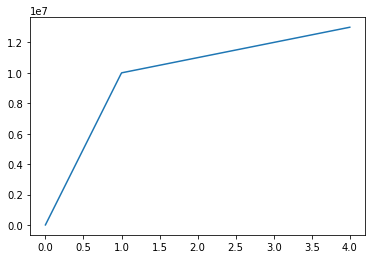

In [4]:
plt.plot(eng_strain,eng_stress)

## Elasto-Plastic Increments

In [5]:
# SUBSEQUENT LOADING, First:+, Second:-
eng_strain = np.append(eng_strain,eng_strain[::-1])

eng_stress = np.empty(eng_strain.size);

def F(stress,strain_p,strain_p_eff):
    return abs(stress - H()*strain_p) - (k_init + E_P*strain_p_eff)
    
def H():
    return 1e6
def E_ELPL(E_EL,E_P,H):
    return E_EL/(E_EL+H()+E_P)*( H() + E_P)

def lam(E_EL,E_P,H,flow):
    return flow * E_EL/(E_EL+H()+E_P)

def flow(stress,p_strain,H):
    return np.sign(stress-H()*p_strain)

strain_increments = np.empty((eng_strain.size -1))

for i in range(eng_strain.size -1):
    strain_increments[i]=eng_strain[i+1]-eng_strain[i]
    
class State:
    ELASTIC, PLASTIC = range(2)
    
p_strain = 0;
e_strain = 0;
p_strain_eff = 0;
stress = 0;  
state = State.ELASTIC

for (i,strain_inc) in enumerate(strain_increments):  
    stress_inc = E_EL*(strain_inc)
    rest = F(stress+stress_inc,p_strain,p_strain_eff)
    if(rest<=0):
        stress += stress_inc
        state = State.ELASTIC
        assert F(stress,p_strain,p_strain_eff) <= 0
    else:
        if(state == State.ELASTIC):
            e_stress_inc = (stress_inc-flow(stress,p_strain,H)*rest)
            stress += e_stress_inc
            e_strain_inc=e_stress_inc/E_EL
            strain_inc = strain_inc - e_strain_inc
            state = State.PLASTIC    
        stress += E_ELPL(E_EL,E_P,H)*(strain_inc)
        p_strain += flow(stress,p_strain,H)*strain_inc *lam(E_EL,E_P,H,flow(stress,p_strain,H))
        p_strain_eff += abs(strain_inc *lam(E_EL,E_P,H,flow(stress,p_strain,H)))
        assert abs(F(stress,p_strain,p_strain_eff)) < 1e-7
    eng_stress[i+1] =stress;

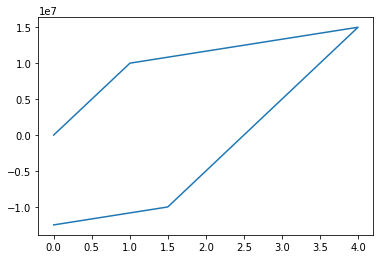

In [6]:
plt.plot(eng_strain,eng_stress)